In [199]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from termcolor import colored

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization
from keras.regularizers import L1, L2
from tensorflow.keras.initializers import HeNormal, RandomUniform
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, AdamW
from tensorflow.keras.layers import Dropout
from tensorflow.keras.utils import to_categorical

In [200]:
all_factuals = pd.read_csv('Mayo_data.csv')
all_factuals

,Age,Gender,Ethnicity,A1C,CarbSize,TotalBolus,del_t,Mode,TotalBasal,PreMeal_BGL_slope,PreMeal_BGL,label
0,65,1,0,5.1,35.0,14.13,0,0.0,2.386667,1.114286,162.0,0.0
1,65,1,0,5.1,50.0,16.67,-30,0.0,1.624583,0.628571,105.0,0.0
2,65,1,0,5.1,58.0,22.06,-35,0.0,2.767833,0.885714,150.0,0.0
3,65,1,0,5.1,60.0,20.00,-45,0.0,1.189667,-0.342857,98.0,0.0
4,65,1,0,5.1,66.0,24.41,45,0.0,1.306750,3.371429,123.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1356,65,1,0,7.2,50.0,24.60,50,0.0,4.029500,-5.342857,97.0,0.0
1357,54,0,1,8.2,50.0,5.00,-45,0.0,0.603917,-7.371429,82.0,0.0
1358,40,1,0,6.3,25.0,3.47,35,0.0,2.113667,-2.000000,111.0,0.0
1359,36,1,0,6.8,10.0,1.55,35,0.0,0.828583,0.857143,158.0,0.0


In [201]:
X = all_factuals.loc[:,:'PreMeal_BGL'].to_numpy()
y = all_factuals.loc[:,'label'].to_numpy()

In [202]:
print('hyperglycemia samples:',y.sum())
print('normoglycemia samples:',y.shape[0]-y.sum())

hyperglycemia samples: 722.0
normoglycemia samples: 639.0


In [203]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state=1)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [204]:
model = Sequential()
model.add(Dense(64, activation='relu', kernel_initializer=HeNormal(), input_shape=(X.shape[1],)))
model.add(BatchNormalization())  
model.add(Dropout(0.3))  

model.add(Dense(32, activation='relu', kernel_initializer=RandomUniform()))
model.add(BatchNormalization())  
model.add(Dropout(0.3)) 

model.add(Dense(32, activation='relu', kernel_initializer=RandomUniform()))
model.add(BatchNormalization())  
model.add(Dropout(0.3)) 

model.add(Dense(2, activation='sigmoid'))  

optimizer = Adam(learning_rate=0.001)  
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy','F1Score'])  
model.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_96 (Dense)            (None, 64)                768       
                                                                 
 batch_normalization_72 (Ba  (None, 64)                256       
 tchNormalization)                                               
                                                                 
 dropout_72 (Dropout)        (None, 64)                0         
                                                                 
 dense_97 (Dense)            (None, 32)                2080      
                                                                 
 batch_normalization_73 (Ba  (None, 32)                128       
 tchNormalization)                                               
                                                                 
 dropout_73 (Dropout)        (None, 32)              

In [205]:
history = model.fit(X_train, y_train,
                    epochs=450, 
                    batch_size=16,  
                    validation_data=(X_test, y_test), 
                    verbose=1)

Epoch 1/450
73/73 [==============================] - 2s 5ms/step - loss: 0.8201 - accuracy: 0.5657 - f1_score: 0.5644 - val_loss: 0.6793 - val_accuracy: 0.5366 - val_f1_score: 0.4064
Epoch 2/450
73/73 [==============================] - 0s 2ms/step - loss: 0.7412 - accuracy: 0.5995 - f1_score: 0.5968 - val_loss: 0.6669 - val_accuracy: 0.5512 - val_f1_score: 0.4285
Epoch 3/450
73/73 [==============================] - 0s 2ms/step - loss: 0.7060 - accuracy: 0.6159 - f1_score: 0.6121 - val_loss: 0.6360 - val_accuracy: 0.6585 - val_f1_score: 0.6254
Epoch 4/450
73/73 [==============================] - 0s 2ms/step - loss: 0.7050 - accuracy: 0.6202 - f1_score: 0.6178 - val_loss: 0.6208 - val_accuracy: 0.6537 - val_f1_score: 0.6278
Epoch 5/450
73/73 [==============================] - 0s 2ms/step - loss: 0.6946 - accuracy: 0.6254 - f1_score: 0.6221 - val_loss: 0.5907 - val_accuracy: 0.7073 - val_f1_score: 0.6975
Epoch 6/450
73/73 [==============================] - 0s 4ms/step - loss: 0.6881 - acc

In [206]:
y_pred_prob = model.predict(X_test)

y_pred = np.argmax(y_pred_prob, axis=1)
y_Test = np.argmax(y_test, axis=1)

# Calculate the F1 score
f1 = f1_score(y_Test, y_pred, average='weighted')
print(colored("Max accuracy:",'green'),round(max(history.history['val_accuracy']),4))
print(colored("F1 Score:",'blue'), round(f1,4))

7/7 [==============================] - 0s 1ms/step
Max accuracy: 0.8146
F1 Score: 0.7891


Text(0, 0.5, 'Loss')

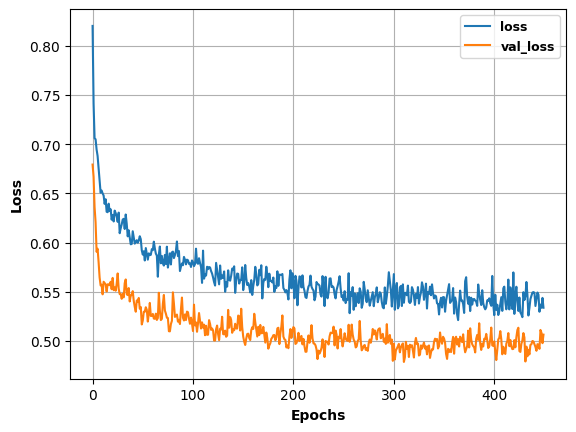

In [207]:
plt.plot(history.history['loss'],label='loss')
plt.plot(history.history['val_loss'],label='val_loss')
plt.legend(labelcolor='black', prop={'weight': 'bold', 'size': 9})
plt.grid(True)
plt.xlabel('Epochs', fontsize=10, weight='bold')
plt.ylabel('Loss', fontsize=10, weight='bold')

In [224]:
history = model.fit(X_train, y_train,
                    epochs=1, 
                    batch_size=16,  
                    validation_data=(X_test, y_test), 
                    verbose=1)

73/73 [==============================] - 0s 2ms/step - loss: 0.5355 - accuracy: 0.7431 - f1_score: 0.7413 - val_loss: 0.5048 - val_accuracy: 0.8098 - val_f1_score: 0.8089


In [226]:
model.save('clf.keras')